In [1]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
import importlib
if 'AZtutorial' in sys.modules:
    importlib.reload(sys.modules['AZtutorial'])
else:
    import AZtutorial
from AZtutorial import *
from IPython.display import Image


from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdmolfiles, rdMolAlign, rdmolops, rdchem, PyMol, Crippen, PropertyMol
from rdkit import DataStructs
from rdkit import RDLogger

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Numerics.rdAlignment import GetAlignmentTransform
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolTransforms
from tqdm import tqdm
from copy import deepcopy

try:
    import cPickle as pickle
except:
    import pickle
import os
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull


@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Populating the interactive namespace from numpy and matplotlib


# Step -3. Set up paths for the workflow

In [2]:

# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'


os.environ['GMXLIB'] = "/home/ykhalak/private/gmx_share_top_w_new_vdwradii"

In [3]:
! echo $GMXLIB

/home/ykhalak/private/gmx_share_top_w_new_vdwradii


In [4]:
! which gmx

/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943/bin/gmx


# Step -2. Select ligands

In [14]:
training_ligand_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket_4d09_protein/processed_69_cl13_ligs_in_4d09_for_ddG_calc.pickle"
with open(training_ligand_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)

reference_lig_name="JAN_PDE2_1345"
for i,l in enumerate(training_ligs):
    if(reference_lig_name in l.GetProp("ID")):
        print(i)
        reference_lig_id=i
        
reference_lig=training_ligs[reference_lig_id]

del training_ligand_databse_fn,training_ligs
import gc
gc.collect()

54


36

In [15]:
folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{folder}/morphing_annealing_4d09_filtered_subset/"

with open(pocket_fit_folder+"/step_6_picks.pickle", 'rb') as f:
    test_ligs = pickle.load(f)

In [ ]:
Draw.MolsToGridImage(test_ligs+[reference_lig],
                     legends=[l.GetProp("ID") for l in test_ligs+[reference_lig]],
                     subImgSize = (400,400), molsPerRow=5, maxMols=101)

# Step -1. Properly parametrize ligands

In [8]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
    mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
    mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
    
    mol_pdb=f"{mol_folder}/mol_gmx.pdb"
    if(not os.path.exists(mol_pdb)):
        with open(mol_pdb,"w") as f:
            f.write(rdmolfiles.MolToPDBBlock(mol))
            
    mol_itp=mol_folder+"/MOL.acpype/MOL_GMX.itp"
    if(not os.path.exists(mol_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        mol_file = "MOL.mol"
        process = subprocess.Popen(['acpype', '-i', mol_file, '-a', 'gaff', '-c', 'bcc', '-b', "MOL", '-n', repr(totQ)],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
        process.wait()
#         out=process.stdout.read().decode("utf-8")
#         err=process.stderr.read().decode("utf-8")
#         print(out)
#         print(err)

        os.system("sed '/\\[ moleculetype \\]/Q' MOL.acpype/MOL_GMX.itp > ffMOL.itp 2>&1")
        os.system("sed -n '/\\[ moleculetype \\]/,$p' MOL.acpype/MOL_GMX.itp > MOL.itp  2>&1")

#         #make sigmahole versions
#         os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
#                   " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
#                   " -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
        mp_lock.acquire()
        if(not os.path.exists(mol_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
        mp_lock.release()
#         break;
    else:
        mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
        mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])

print("Now the pool is closed and no longer available")

set4_190778 	 starting in process 11134
set4_122463 	 starting in process 11135
set4_190844 	 starting in process 11136
set4_73375 	 starting in process 11137
set4_73375 	 done parametrizing
set4_204549 	 starting in process 11137
set4_190844 	 done parametrizing
set4_73008 	 starting in process 11136
set4_190778 	 done parametrizing
set4_240291 	 starting in process 11134
set4_122463 	 done parametrizing
set4_71401 	 starting in process 11135
set4_204549 	 done parametrizing
set4_122460 	 starting in process 11137
set4_71401 	 done parametrizing
set4_73883 	 starting in process 11135
set4_73883 	 done parametrizing
set4_202087 	 starting in process 11135
set4_73008 	 done parametrizing
set4_316733 	 starting in process 11136
set4_202087 	 done parametrizing
set4_357530 	 starting in process 11135
set4_240291 	 done parametrizing
set4_204497 	 starting in process 11134
set4_316733 	 done parametrizing
set4_287307 	 starting in process 11136
set4_204497 	 done parametrizing
set4_121483 

In [9]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
#     mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
#     mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
            
    mol_sigmahole_itp=mol_folder+"/MOL_sigmahole.itp"
    if(not os.path.exists(mol_sigmahole_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        
        #make sigmahole versions
        os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
                  " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
                  f" -q {totQ} -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
#         mp_lock.acquire()
        if(not os.path.exists(mol_sigmahole_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
#         mp_lock.release()
#         break;
    else:
#         mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
#         mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])



set4_190778 	 starting in process set4_12246326554 
	 starting in processset4_190844 	 starting in process  
26555
set4_73375 	 starting in process 2655726556
set4_122463 	 done parametrizing
set4_71401 	 starting in process 26555
set4_190778 	 done parametrizing
set4_240291 	 starting in process 26554
set4_73375set4_190844  	 done parametrizing	 done parametrizing
set4_204549
set4_73008 	 starting in process  	 starting in process26557 
26556
set4_71401 	 done parametrizing
set4_73883 	 starting in process 26555
set4_204549 	 done parametrizing
set4_122460 	 starting in process 26557
set4_240291set4_73008 	 done parametrizing
set4_316733 	 starting in process 26556
 	 done parametrizing
set4_204497 	 starting in process 26554
set4_73883 	 done parametrizing
set4_202087 	 starting in process 26555
set4_204497 	 done parametrizing
set4_121483 	 starting in process 26554
set4_316733 	 done parametrizing
set4_287307 set4_122460 	 starting in process	 done parametrizing
 set4_31593126556 


----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [17]:
# provide edges
fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe.simTypes = ['em','eq_posre','eq','transitions']
#fe.simTypes = ['em','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )


edge_JAN_PDE2_1345_set4_122405
edge_JAN_PDE2_1345_set4_186436
edge_JAN_PDE2_1345_set4_122454
edge_JAN_PDE2_1345_set4_240240
edge_JAN_PDE2_1345_set4_71840
edge_JAN_PDE2_1345_set4_10001
edge_JAN_PDE2_1345_set4_71037
edge_JAN_PDE2_1345_set4_122470
edge_JAN_PDE2_1345_set4_71680
edge_JAN_PDE2_1345_set4_235794
edge_JAN_PDE2_1345_set4_72058
edge_JAN_PDE2_1345_set4_282407
edge_JAN_PDE2_1345_set4_202295
edge_JAN_PDE2_1345_set4_73943
edge_JAN_PDE2_1345_set4_240198
edge_JAN_PDE2_1345_set4_287350
edge_JAN_PDE2_1345_set4_318281
edge_JAN_PDE2_1345_set4_287267
edge_JAN_PDE2_1345_set4_204426
edge_JAN_PDE2_1345_set4_73956
edge_JAN_PDE2_1345_set4_122371
edge_JAN_PDE2_1345_set4_358465
edge_JAN_PDE2_1345_set4_282779
edge_JAN_PDE2_1345_set4_122450
edge_JAN_PDE2_1345_set4_72590
edge_JAN_PDE2_1345_set4_358475
edge_JAN_PDE2_1345_set4_12320
edge_JAN_PDE2_1345_set4_48415
edge_JAN_PDE2_1345_set4_314384
edge_JAN_PDE2_1345_set4_117750
edge_JAN_PDE2_1345_set4_287280
edge_JAN_PDE2_1345_set4_122415
edge_JAN_PDE2_1345

`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [11]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False, n_processes=8)
#fe.atom_mapping(bVerbose=True)

-----------------------
Performing atom mapping
-----------------------
edge_JAN_PDE2_1345_set4_190778
edge_JAN_PDE2_1345_set4_46560
edge_JAN_PDE2_1345_set4_190914
edge_JAN_PDE2_1345_set4_71401
edge_JAN_PDE2_1345_set4_315931
edge_JAN_PDE2_1345_set4_316733
edge_JAN_PDE2_1345_set4_49417
edge_JAN_PDE2_1345_set4_318412
edge_JAN_PDE2_1345_set4_72639
edge_JAN_PDE2_1345_set4_287307
edge_JAN_PDE2_1345_set4_46739
edge_JAN_PDE2_1345_set4_240291
edge_JAN_PDE2_1345_set4_314311
edge_JAN_PDE2_1345_set4_73883
edge_JAN_PDE2_1345_set4_200839
edge_JAN_PDE2_1345_set4_73375
edge_JAN_PDE2_1345_set4_9233
edge_JAN_PDE2_1345_set4_204497
edge_JAN_PDE2_1345_set4_39459
edge_JAN_PDE2_1345_set4_202087
edge_JAN_PDE2_1345_set4_190844
edge_JAN_PDE2_1345_set4_204487
edge_JAN_PDE2_1345_set4_204549
edge_JAN_PDE2_1345_set4_44746
edge_JAN_PDE2_1345_set4_121483
edge_JAN_PDE2_1345_set4_239416
edge_JAN_PDE2_1345_set4_122463
edge_JAN_PDE2_1345_set4_357530
edge_JAN_PDE2_1345_set4_200519
edge_JAN_PDE2_1345_set4_190886
edge_JAN_

`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [12]:
# import importlib
# if 'AZtutorial' in sys.modules:
#     importlib.reload(sys.modules['AZtutorial'])
# else:
#     import AZtutorial
# from AZtutorial import *

# # initialize the free energy environment object: it will store the main parameters for the calculations
# fe = AZtutorial( )

# # set the workpath
# fe.workPath = 'workpath'
# # set the path to the molecular dynamics parameter files
# fe.mdpPath = 'input/mdppath'
# # set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
# fe.replicas = 3
# # provide the path to the protein structure and topology
# fe.proteinPath = 'input/protein_amber'
# # provide the path to the folder with ligand structures and topologies
# fe.ligandPath = 'input/ligands'

# # provide edges
# fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
# fe.simTypes = ['em','eq_posre','eq','transitions']
# #fe.simTypes = ['em','eq','transitions']

# # finally, let's prepare the overall free energy calculation directory structure
# fe.prepareFreeEnergyDir( )

In [13]:
fe.hybrid_structure_topology(bVerbose=False, n_processes=1, DummyMassScale=0.001)

----------------------------------
Creating hybrid structure/topology
----------------------------------
edge_JAN_PDE2_1345_set4_190778
edge_JAN_PDE2_1345_set4_240291
edge_JAN_PDE2_1345_set4_204497
edge_JAN_PDE2_1345_set4_121483
edge_JAN_PDE2_1345_set4_190914
edge_JAN_PDE2_1345_set4_314311
edge_JAN_PDE2_1345_set4_39459
edge_JAN_PDE2_1345_set4_122463
edge_JAN_PDE2_1345_set4_71401
edge_JAN_PDE2_1345_set4_73883
edge_JAN_PDE2_1345_set4_202087
edge_JAN_PDE2_1345_set4_357530
edge_JAN_PDE2_1345_set4_46560
edge_JAN_PDE2_1345_set4_72639
edge_JAN_PDE2_1345_set4_190844
edge_JAN_PDE2_1345_set4_73008
edge_JAN_PDE2_1345_set4_316733
edge_JAN_PDE2_1345_set4_287307
edge_JAN_PDE2_1345_set4_9233
edge_JAN_PDE2_1345_set4_239416
edge_JAN_PDE2_1345_set4_49417
edge_JAN_PDE2_1345_set4_73375
edge_JAN_PDE2_1345_set4_204549
edge_JAN_PDE2_1345_set4_122460
edge_JAN_PDE2_1345_set4_315931
edge_JAN_PDE2_1345_set4_46739
edge_JAN_PDE2_1345_set4_44746
edge_JAN_PDE2_1345_set4_190886
edge_JAN_PDE2_1345_set4_318412
edge_JAN

`1c. Generate position restraints for the ligands`

In [14]:
fe.hybrid_structure_restraints(bVerbose=False, n_processes=8)

-----------------------------------------------
Creating position restraints for hybrid ligands
-----------------------------------------------
edge_JAN_PDE2_1345_set4_315931
edge_JAN_PDE2_1345_set4_190778
edge_JAN_PDE2_1345_set4_318412
edge_JAN_PDE2_1345_set4_71401
edge_JAN_PDE2_1345_set4_46560
edge_JAN_PDE2_1345_set4_316733
edge_JAN_PDE2_1345_set4_49417
edge_JAN_PDE2_1345_set4_190914
edge_JAN_PDE2_1345_set4_73375
edge_JAN_PDE2_1345_set4_200839
edge_JAN_PDE2_1345_set4_73883
edge_JAN_PDE2_1345_set4_240291
edge_JAN_PDE2_1345_set4_287307
edge_JAN_PDE2_1345_set4_46739
edge_JAN_PDE2_1345_set4_72639
edge_JAN_PDE2_1345_set4_314311
edge_JAN_PDE2_1345_set4_204487
edge_JAN_PDE2_1345_set4_202087
edge_JAN_PDE2_1345_set4_44746
edge_JAN_PDE2_1345_set4_204549
edge_JAN_PDE2_1345_set4_9233
edge_JAN_PDE2_1345_set4_204497
edge_JAN_PDE2_1345_set4_190844
edge_JAN_PDE2_1345_set4_357530
edge_JAN_PDE2_1345_set4_200519
edge_JAN_PDE2_1345_set4_39459
edge_JAN_PDE2_1345_set4_190886
edge_JAN_PDE2_1345_set4_122460

`1d. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [15]:
prot_extra_mols={}
prot_extra_mols["MG"]=1
prot_extra_mols["ZN"]=1
prot_extra_mols["SOL"]=88

fe.assemble_systems( filter_prot_water=True, prot_extra_mols=prot_extra_mols)

----------------------
Assembling the systems
----------------------
edge_JAN_PDE2_1345_set4_190778


/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.

changing number of waters to 87
edge_JAN_PDE2_1345_set4_240291
changing number of waters to 86
edge_JAN_PDE2_1345_set4_204497
changing number of waters to 87
edge_JAN_PDE2_1345_set4_121483
changing number of waters to 87
edge_JAN_PDE2_1345_set4_190914
changing number of waters to 87
edge_JAN_PDE2_1345_set4_314311
edge_JAN_PDE2_1345_set4_39459
changing number of waters to 87
edge_JAN_PDE2_1345_set4_122463
changing number of waters to 87
edge_JAN_PDE2_1345_set4_71401
changing number of waters to 87
edge_JAN_PDE2_1345_set4_73883
changing number of waters to 87
edge_JAN_PDE2_1345_set4_202087
changing number of waters to 87
edge_JAN_PDE2_1345_set4_357530
changing number of waters to 87
edge_JAN_PDE2_1345_set4_46560
changing number of waters to 87
edge_JAN_PDE2_1345_set4_72639
changing number of waters to 86
edge_JAN_PDE2_1345_set4_190844
changing number of waters to 86
edge_JAN_PDE2_1345_set4_73008
changing number of waters to 87
edge_JAN_PDE2_1345_set4_316733
edge_JAN_PDE2_1345_set4_287307

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [16]:
fe.boxWaterIons(    bBoxLig=True, bBoxProt=True, 
                    bWatLig=True, bWatProt=True,
                    bIonLig=True, bIonProt=True, n_processes=4 )

----------------
Box, water, ions
----------------
edge_JAN_PDE2_1345_set4_122463
edge_JAN_PDE2_1345_set4_190844
edge_JAN_PDE2_1345_set4_190778
edge_JAN_PDE2_1345_set4_73375


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_240291
edge_JAN_PDE2_1345_set4_71401
edge_JAN_PDE2_1345_set4_73008
edge_JAN_PDE2_1345_set4_204549


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204497
edge_JAN_PDE2_1345_set4_73883
edge_JAN_PDE2_1345_set4_316733
edge_JAN_PDE2_1345_set4_122460


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_121483
edge_JAN_PDE2_1345_set4_202087
edge_JAN_PDE2_1345_set4_287307
edge_JAN_PDE2_1345_set4_315931


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
IndexFile has group MG !! 
Group UNL will be replaced !!
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_190914
edge_JAN_PDE2_1345_set4_357530
edge_JAN_PDE2_1345_set4_46739
edge_JAN_PDE2_1345_set4_9233


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_46560
edge_JAN_PDE2_1345_set4_314311
edge_JAN_PDE2_1345_set4_239416
edge_JAN_PDE2_1345_set4_44746


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_72639
edge_JAN_PDE2_1345_set4_39459
edge_JAN_PDE2_1345_set4_190886
edge_JAN_PDE2_1345_set4_49417


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!IndexFile has group MG !! 

Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_318412
edge_JAN_PDE2_1345_set4_72643
edge_JAN_PDE2_1345_set4_73813
edge_JAN_PDE2_1345_set4_73153


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_200839
edge_JAN_PDE2_1345_set4_121481
edge_JAN_PDE2_1345_set4_318340
edge_JAN_PDE2_1345_set4_186054


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_73724
edge_JAN_PDE2_1345_set4_204487
edge_JAN_PDE2_1345_set4_71992
edge_JAN_PDE2_1345_set4_72600


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_200519


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_49347


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_188271


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_121458
edge_JAN_PDE2_1345_set4_204450


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204435


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_73007
edge_JAN_PDE2_1345_set4_287108
edge_JAN_PDE2_1345_set4_190882


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_316574


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_26471


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_287305
edge_JAN_PDE2_1345_set4_122489


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_187035


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_190807


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204316
edge_JAN_PDE2_1345_set4_186899
edge_JAN_PDE2_1345_set4_358538
edge_JAN_PDE2_1345_set4_12907


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_122477
edge_JAN_PDE2_1345_set4_315639
edge_JAN_PDE2_1345_set4_315054
edge_JAN_PDE2_1345_set4_358553


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_7468
edge_JAN_PDE2_1345_set4_117342
edge_JAN_PDE2_1345_set4_237843
edge_JAN_PDE2_1345_set4_316584


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!IndexFile has group MG !! 

Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_121456
edge_JAN_PDE2_1345_set4_49395
edge_JAN_PDE2_1345_set4_122492
edge_JAN_PDE2_1345_set4_240197


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! IndexFile has group MG !! 
Group UNL will be replaced !!

Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_120342
edge_JAN_PDE2_1345_set4_240165
edge_JAN_PDE2_1345_set4_204440


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_376385
edge_JAN_PDE2_1345_set4_315055
edge_JAN_PDE2_1345_set4_46563


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_73781
edge_JAN_PDE2_1345_set4_204476


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!


edge_JAN_PDE2_1345_set4_297010


IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_200493
edge_JAN_PDE2_1345_set4_1830
edge_JAN_PDE2_1345_set4_282491

IndexFile has group MG !! 


Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_240139


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_287279
edge_JAN_PDE2_1345_set4_287340
edge_JAN_PDE2_1345_set4_48416


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204510
edge_JAN_PDE2_1345_set4_12308


IndexFile has group MG !! 
Group MG will be replaced !!


edge_JAN_PDE2_1345_set4_190853


IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_73446
edge_JAN_PDE2_1345_set4_7467


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_190819
edge_JAN_PDE2_1345_set4_49408


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_200833
edge_JAN_PDE2_1345_set4_318271


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_7276
edge_JAN_PDE2_1345_set4_295347


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_43306
edge_JAN_PDE2_1345_set4_28055


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


DONE


`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [17]:
fe.prepare_simulation( simType='em', bLig=True, bProt=True, n_processes=8  )

-----------------------------------------
Preparing simulation: em
-----------------------------------------
edge_JAN_PDE2_1345_set4_316733
edge_JAN_PDE2_1345_set4_190914
edge_JAN_PDE2_1345_set4_190778
edge_JAN_PDE2_1345_set4_71401
edge_JAN_PDE2_1345_set4_46560
edge_JAN_PDE2_1345_set4_315931
edge_JAN_PDE2_1345_set4_49417
edge_JAN_PDE2_1345_set4_318412
edge_JAN_PDE2_1345_set4_314311
edge_JAN_PDE2_1345_set4_46739
edge_JAN_PDE2_1345_set4_73375
edge_JAN_PDE2_1345_set4_72639
edge_JAN_PDE2_1345_set4_73883
edge_JAN_PDE2_1345_set4_240291
edge_JAN_PDE2_1345_set4_287307
edge_JAN_PDE2_1345_set4_200839
edge_JAN_PDE2_1345_set4_39459
edge_JAN_PDE2_1345_set4_44746
edge_JAN_PDE2_1345_set4_190844
edge_JAN_PDE2_1345_set4_204549
edge_JAN_PDE2_1345_set4_204487
edge_JAN_PDE2_1345_set4_202087
edge_JAN_PDE2_1345_set4_9233
edge_JAN_PDE2_1345_set4_204497
edge_JAN_PDE2_1345_set4_121483
edge_JAN_PDE2_1345_set4_357530
edge_JAN_PDE2_1345_set4_190886
edge_JAN_PDE2_1345_set4_122460
edge_JAN_PDE2_1345_set4_73008
edge

Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
#fe.run_simulation_locally( simType='em', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads_d"])

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [18]:
# set several parameters
#fe.JOBqueue = 'SGE'
#fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
#fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
#fe.JOBpartition = 'p20'

fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


In [18]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


# Check what stages are finished

In [40]:
print("protein:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                


simType='eq_posre'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

protein:
	 em


KeyboardInterrupt: 

In [27]:
print("water:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 em
	 eq


# Posre only for Prot

`prepare and run NVT with simulated annealing to get the temp up smoothly`

In [22]:
fe.prepare_simulation( simType='eq_posre', bProt=True, bLig=False, n_processes=8)

-----------------------------------------
Preparing simulation: eq_posre
-----------------------------------------
edge_JAN_PDE2_1345_set4_314384
edge_JAN_PDE2_1345_set4_122405
edge_JAN_PDE2_1345_set4_71840
edge_JAN_PDE2_1345_set4_122371
edge_JAN_PDE2_1345_set4_71680
edge_JAN_PDE2_1345_set4_318281
edge_JAN_PDE2_1345_set4_202295
edge_JAN_PDE2_1345_set4_72590
edge_JAN_PDE2_1345_set4_186436
edge_JAN_PDE2_1345_set4_10001
edge_JAN_PDE2_1345_set4_358475
edge_JAN_PDE2_1345_set4_287267
edge_JAN_PDE2_1345_set4_117750
edge_JAN_PDE2_1345_set4_358465
edge_JAN_PDE2_1345_set4_235794
edge_JAN_PDE2_1345_set4_73943
edge_JAN_PDE2_1345_set4_71037
edge_JAN_PDE2_1345_set4_12320
edge_JAN_PDE2_1345_set4_122454
edge_JAN_PDE2_1345_set4_72058
edge_JAN_PDE2_1345_set4_204426
edge_JAN_PDE2_1345_set4_287280
edge_JAN_PDE2_1345_set4_240198
edge_JAN_PDE2_1345_set4_282779
edge_JAN_PDE2_1345_set4_122470
edge_JAN_PDE2_1345_set4_240240
edge_JAN_PDE2_1345_set4_48415
edge_JAN_PDE2_1345_set4_73956
edge_JAN_PDE2_1345_set4_282

In [ ]:
#fe.run_simulation_locally( simType='eq_posre', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

In [24]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
fe.JOBpartition = 'p20'
#fe.JOBpartition = 'p20,p16,p10,p08'

fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


In [23]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


### Check eq_posre completition

In [33]:
simType='eq_posre'
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

In [27]:
# # TI xvgs are incomplete and NPT took a long time
# unstable_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
# ]

# stable_edges={e:fe.edges[e] for e in fe.edges if e not in unstable_edges_names}

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [25]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=stable_edges)
# fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_72590
edge_JAN_PDE2_1345_set4_318281
edge_JAN_PDE2_1345_set4_122405
edge_JAN_PDE2_1345_set4_71840
edge_JAN_PDE2_1345_set4_202295
edge_JAN_PDE2_1345_set4_71680
edge_JAN_PDE2_1345_set4_314384
edge_JAN_PDE2_1345_set4_122371
edge_JAN_PDE2_1345_set4_235794
edge_JAN_PDE2_1345_set4_117750
edge_JAN_PDE2_1345_set4_358465
edge_JAN_PDE2_1345_set4_10001
edge_JAN_PDE2_1345_set4_358475
edge_JAN_PDE2_1345_set4_287267
edge_JAN_PDE2_1345_set4_73943
edge_JAN_PDE2_1345_set4_186436
edge_JAN_PDE2_1345_set4_72058
edge_JAN_PDE2_1345_set4_71037
edge_JAN_PDE2_1345_set4_287280
edge_JAN_PDE2_1345_set4_282779
edge_JAN_PDE2_1345_set4_204426
edge_JAN_PDE2_1345_set4_240198
edge_JAN_PDE2_1345_set4_12320
edge_JAN_PDE2_1345_set4_122454
edge_JAN_PDE2_1345_set4_282407
edge_JAN_PDE2_1345_set4_122470
edge_JAN_PDE2_1345_set4_122450
edge_JAN_PDE2_1345_set4_122415
edge_JAN_PDE2_1345_set4_73956
e

In [ ]:
#fe.run_simulation_locally( simType='eq', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [27]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 23 # hours
#fe.JOBpartition = 'p20'
fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


In [36]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 10 # hours

#fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges)
fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_71680
edge_JAN_PDE2_1345_set4_314384
edge_JAN_PDE2_1345_set4_72590
edge_JAN_PDE2_1345_set4_71840
edge_JAN_PDE2_1345_set4_202295
edge_JAN_PDE2_1345_set4_122405
edge_JAN_PDE2_1345_set4_122371
edge_JAN_PDE2_1345_set4_318281
edge_JAN_PDE2_1345_set4_73943
edge_JAN_PDE2_1345_set4_10001
edge_JAN_PDE2_1345_set4_117750
edge_JAN_PDE2_1345_set4_358465
edge_JAN_PDE2_1345_set4_235794
edge_JAN_PDE2_1345_set4_287267
edge_JAN_PDE2_1345_set4_186436
edge_JAN_PDE2_1345_set4_358475
edge_JAN_PDE2_1345_set4_72058
edge_JAN_PDE2_1345_set4_204426
edge_JAN_PDE2_1345_set4_12320
edge_JAN_PDE2_1345_set4_122454
edge_JAN_PDE2_1345_set4_71037
edge_JAN_PDE2_1345_set4_240198
edge_JAN_PDE2_1345_set4_287280
edge_JAN_PDE2_1345_set4_282779
edge_JAN_PDE2_1345_set4_73956
edge_JAN_PDE2_1345_set4_282407
edge_JAN_PDE2_1345_set4_122470
edge_JAN_PDE2_1345_set4_122450
edge_JAN_PDE2_1345_set4_122415
e

# exclude slow running edges (NPT not done yet)

In [18]:
# find slow-running edges
slow_edges_names=[]

simType='eq'
print("\t", simType)
print("\t\t protein")
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                slow_edges_names.append(edge)
                
print("\t\t water")
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                slow_edges_names.append(edge)
                
#make sure they are unique
slow_edges_names=list(set(slow_edges_names))

	 eq
		 protein
		 water


In [31]:
# slow_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
#     "edge_JAN_PDE2_1345_set4_5596"
# ]

In [19]:
normal_edges={e:fe.edges[e] for e in fe.edges if e not in slow_edges_names}
slow_edges={e:fe.edges[e] for e in fe.edges if e in slow_edges_names}
print(slow_edges)

{}


# Run TI on the edges that finished eq
no unstable opnes this time

In [43]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 12 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=normal_edges )
# fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=slow_edges, job_folder_suffix="_from_slow_NPT" )
# fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# Check structure of unstable lig

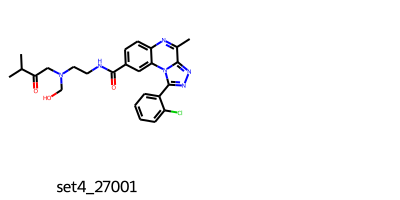

In [19]:
unstable_ligs=[]
unstable_lignames=[]
for i,l in enumerate(test_ligs):
    if("edge_JAN_PDE2_1345_"+l.GetProp("ID") in unstable_edges_names):
        unstable_ligs.append(l)
        unstable_lignames.append(l.GetProp("ID"))

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(lig))for lig in unstable_ligs], legends=unstable_lignames,
                     subImgSize = (200,200), molsPerRow=2, maxMols=10)

# Analysis

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [69]:
# # TI xvgs are incomplete and NPT took a long time
# not_finsished_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
#     "edge_JAN_PDE2_1345_set4_5596",
# #     "edge_JAN_PDE2_1345_set4_42807",
# #     "edge_JAN_PDE2_1345_set4_375984"
# ]

# finished_edges={e:fe.edges[e] for e in fe.edges if e not in not_finsished_edges_names}

In [20]:
# build a list of finished edges

finished_edges_names=[]

for edge in tqdm(fe.edges):
    fin=[False]*fe.replicas
    for r in range(1,fe.replicas+1):
        # ligand
        wp = 'water'
        analysispath = '{0}/analyse{1}'.format(fe._get_specific_path(edge=edge,wp=wp),r)
        create_folder(analysispath)
        stateApath = fe._get_specific_path(edge=edge,wp=wp,state='stateA',r=r,sim='transitions')
        stateBpath = fe._get_specific_path(edge=edge,wp=wp,state='stateB',r=r,sim='transitions')
        gA_w = glob.glob('{0}/*xvg'.format(stateApath))
        gB_w = glob.glob('{0}/*xvg'.format(stateBpath))

        # protein
        wp = 'protein'
        analysispath = '{0}/analyse{1}'.format(fe._get_specific_path(edge=edge,wp=wp),r)
        create_folder(analysispath)
        stateApath = fe._get_specific_path(edge=edge,wp=wp,state='stateA',r=r,sim='transitions')
        stateBpath = fe._get_specific_path(edge=edge,wp=wp,state='stateB',r=r,sim='transitions')
        gA_p = glob.glob('{0}/*xvg'.format(stateApath))
        gB_p = glob.glob('{0}/*xvg'.format(stateBpath))

        if(len(gA_w)>=80 and len(gB_w)>=80 and len(gA_p)>=80 and len(gB_p)>=80):
            fin[r-1]=True
    if(all(fin)):
        finished_edges_names.append(edge)

finished_edges={e:fe.edges[e] for e in finished_edges_names}
# print(finished_edges)
print(len(finished_edges))

100%|██████████| 100/100 [00:15<00:00,  6.30it/s]

100


In [21]:
#fe.run_analysis( bVerbose=True)

# excluded=["edge_JAN_PDE2_1345_JAN_PDE2_994"] # we don't have water for this one yet
# ana_edges={x: fe.edges[x] for x in fe.edges if x not in excluded}
# fe.run_analysis(edges=ana_edges, bLig=False, bProt=True, bVerbose=False)

# fe.run_analysis( bLig=False, bProt=True, bVerbose=False)
# fe.run_analysis( bLig=True, bProt=True, bVerbose=False, only_check_completition=True)
# fe.run_analysis( bLig=True, bProt=True, bVerbose=False,
#                  n_processes=min(8, len(finished_edges)),
#                  edges=finished_edges )
fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8)

----------------
Running analysis
----------------
edge_JAN_PDE2_1345_set4_202295
edge_JAN_PDE2_1345_set4_318281
edge_JAN_PDE2_1345_set4_122405
edge_JAN_PDE2_1345_set4_71840
edge_JAN_PDE2_1345_set4_71680
edge_JAN_PDE2_1345_set4_122371
edge_JAN_PDE2_1345_set4_72590
edge_JAN_PDE2_1345_set4_314384
edge_JAN_PDE2_1345_set4_186436
edge_JAN_PDE2_1345_set4_10001
edge_JAN_PDE2_1345_set4_358475
edge_JAN_PDE2_1345_set4_235794
edge_JAN_PDE2_1345_set4_122454
edge_JAN_PDE2_1345_set4_117750
edge_JAN_PDE2_1345_set4_71037
edge_JAN_PDE2_1345_set4_12320
edge_JAN_PDE2_1345_set4_287280
edge_JAN_PDE2_1345_set4_72058
edge_JAN_PDE2_1345_set4_122470
edge_JAN_PDE2_1345_set4_240240
edge_JAN_PDE2_1345_set4_48415
edge_JAN_PDE2_1345_set4_122421
edge_JAN_PDE2_1345_set4_10429
edge_JAN_PDE2_1345_set4_240204
edge_JAN_PDE2_1345_set4_187660
edge_JAN_PDE2_1345_set4_71769
edge_JAN_PDE2_1345_set4_39238
edge_JAN_PDE2_1345_set4_190843
edge_JAN_PDE2_1345_set4_122467
edge_JAN_PDE2_1345_set4_240241
edge_JAN_PDE2_1345_set4_190911

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [22]:
fe.replicas = 3
fe.analysis_summary( edges=finished_edges )
# fe.analysis_summary()

In [23]:
fe.resultsAll

,val,err_analyt,err_boot,framesA,framesB
edge_JAN_PDE2_1345_set4_122405_water_1,46.700000,4.530000,2.160000,80.0,80.0
edge_JAN_PDE2_1345_set4_122405_protein_1,31.230000,590.840000,2.190000,80.0,80.0
edge_JAN_PDE2_1345_set4_122405_water_2,56.300000,9.950000,1.890000,80.0,80.0
edge_JAN_PDE2_1345_set4_122405_protein_2,31.930000,90.670000,2.210000,80.0,80.0
edge_JAN_PDE2_1345_set4_122405_water_3,49.580000,6.060000,1.470000,80.0,80.0
...,...,...,...,...,...
edge_JAN_PDE2_1345_set4_122475_protein,48.223333,12.741725,2.696841,NaN,NaN
edge_JAN_PDE2_1345_set4_122494_water,-49.566667,1.275741,1.583589,NaN,NaN
edge_JAN_PDE2_1345_set4_122494_protein,-64.060000,16.120121,2.289712,NaN,NaN
edge_JAN_PDE2_1345_set4_44266_water,9.173333,1.600020,1.251131,NaN,NaN


In [24]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsAll)

                                                 val  err_analyt   err_boot  \
edge_JAN_PDE2_1345_set4_122405_water_1     46.700000    4.530000   2.160000   
edge_JAN_PDE2_1345_set4_122405_protein_1   31.230000  590.840000   2.190000   
edge_JAN_PDE2_1345_set4_122405_water_2     56.300000    9.950000   1.890000   
edge_JAN_PDE2_1345_set4_122405_protein_2   31.930000   90.670000   2.210000   
edge_JAN_PDE2_1345_set4_122405_water_3     49.580000    6.060000   1.470000   
edge_JAN_PDE2_1345_set4_122405_protein_3   36.230000   19.630000  10.540000   
edge_JAN_PDE2_1345_set4_186436_water_1    -15.080000    2.870000   2.200000   
edge_JAN_PDE2_1345_set4_186436_protein_1  -33.510000   16.530000   3.050000   
edge_JAN_PDE2_1345_set4_186436_water_2    -15.540000    1.470000   1.760000   
edge_JAN_PDE2_1345_set4_186436_protein_2  -28.370000    9.320000   2.090000   
edge_JAN_PDE2_1345_set4_186436_water_3    -10.990000    2.100000   3.300000   
edge_JAN_PDE2_1345_set4_186436_protein_3  -38.070000

In [25]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsSummary)

                                      val  err_analyt  err_boot
edge_JAN_PDE2_1345_set4_122405 -17.730000  192.887915  4.571019
edge_JAN_PDE2_1345_set4_186436 -19.446667    7.163654  3.252248
edge_JAN_PDE2_1345_set4_122454 -22.673333    9.712677  3.179101
edge_JAN_PDE2_1345_set4_240240 -16.300000    5.193720  2.893413
edge_JAN_PDE2_1345_set4_71840  -17.556667    5.429153  2.531743
edge_JAN_PDE2_1345_set4_10001  -14.860000   79.922515  2.942836
edge_JAN_PDE2_1345_set4_71037   -8.796667    7.157554  3.782792
edge_JAN_PDE2_1345_set4_122470 -16.413333    5.126361  3.581680
edge_JAN_PDE2_1345_set4_71680  -22.616667    6.215350  2.408024
edge_JAN_PDE2_1345_set4_235794 -14.543333   33.918538  4.324299
edge_JAN_PDE2_1345_set4_72058  -24.300000    4.457721  2.875531
edge_JAN_PDE2_1345_set4_282407 -17.460000   14.113498  2.596695
edge_JAN_PDE2_1345_set4_202295 -19.393333    8.039594  2.817025
edge_JAN_PDE2_1345_set4_73943  -16.043333   29.015692  3.006065
edge_JAN_PDE2_1345_set4_240198 -19.89666

In [27]:
def grid_mols_with_annotation(mols, labels, sub_img_size=(250,250), mols_per_row=10, title="", annotation_size=22, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, maxMols=len(mols), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size[0]/2, sub_img_size[1]+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        plt.annotate(cmpd_text, text_pos, fontsize=annotation_size, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size[0], text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size[0]/2, text_pos[1] + sub_img_size[1])

    ax.imshow(img, origin="upper")

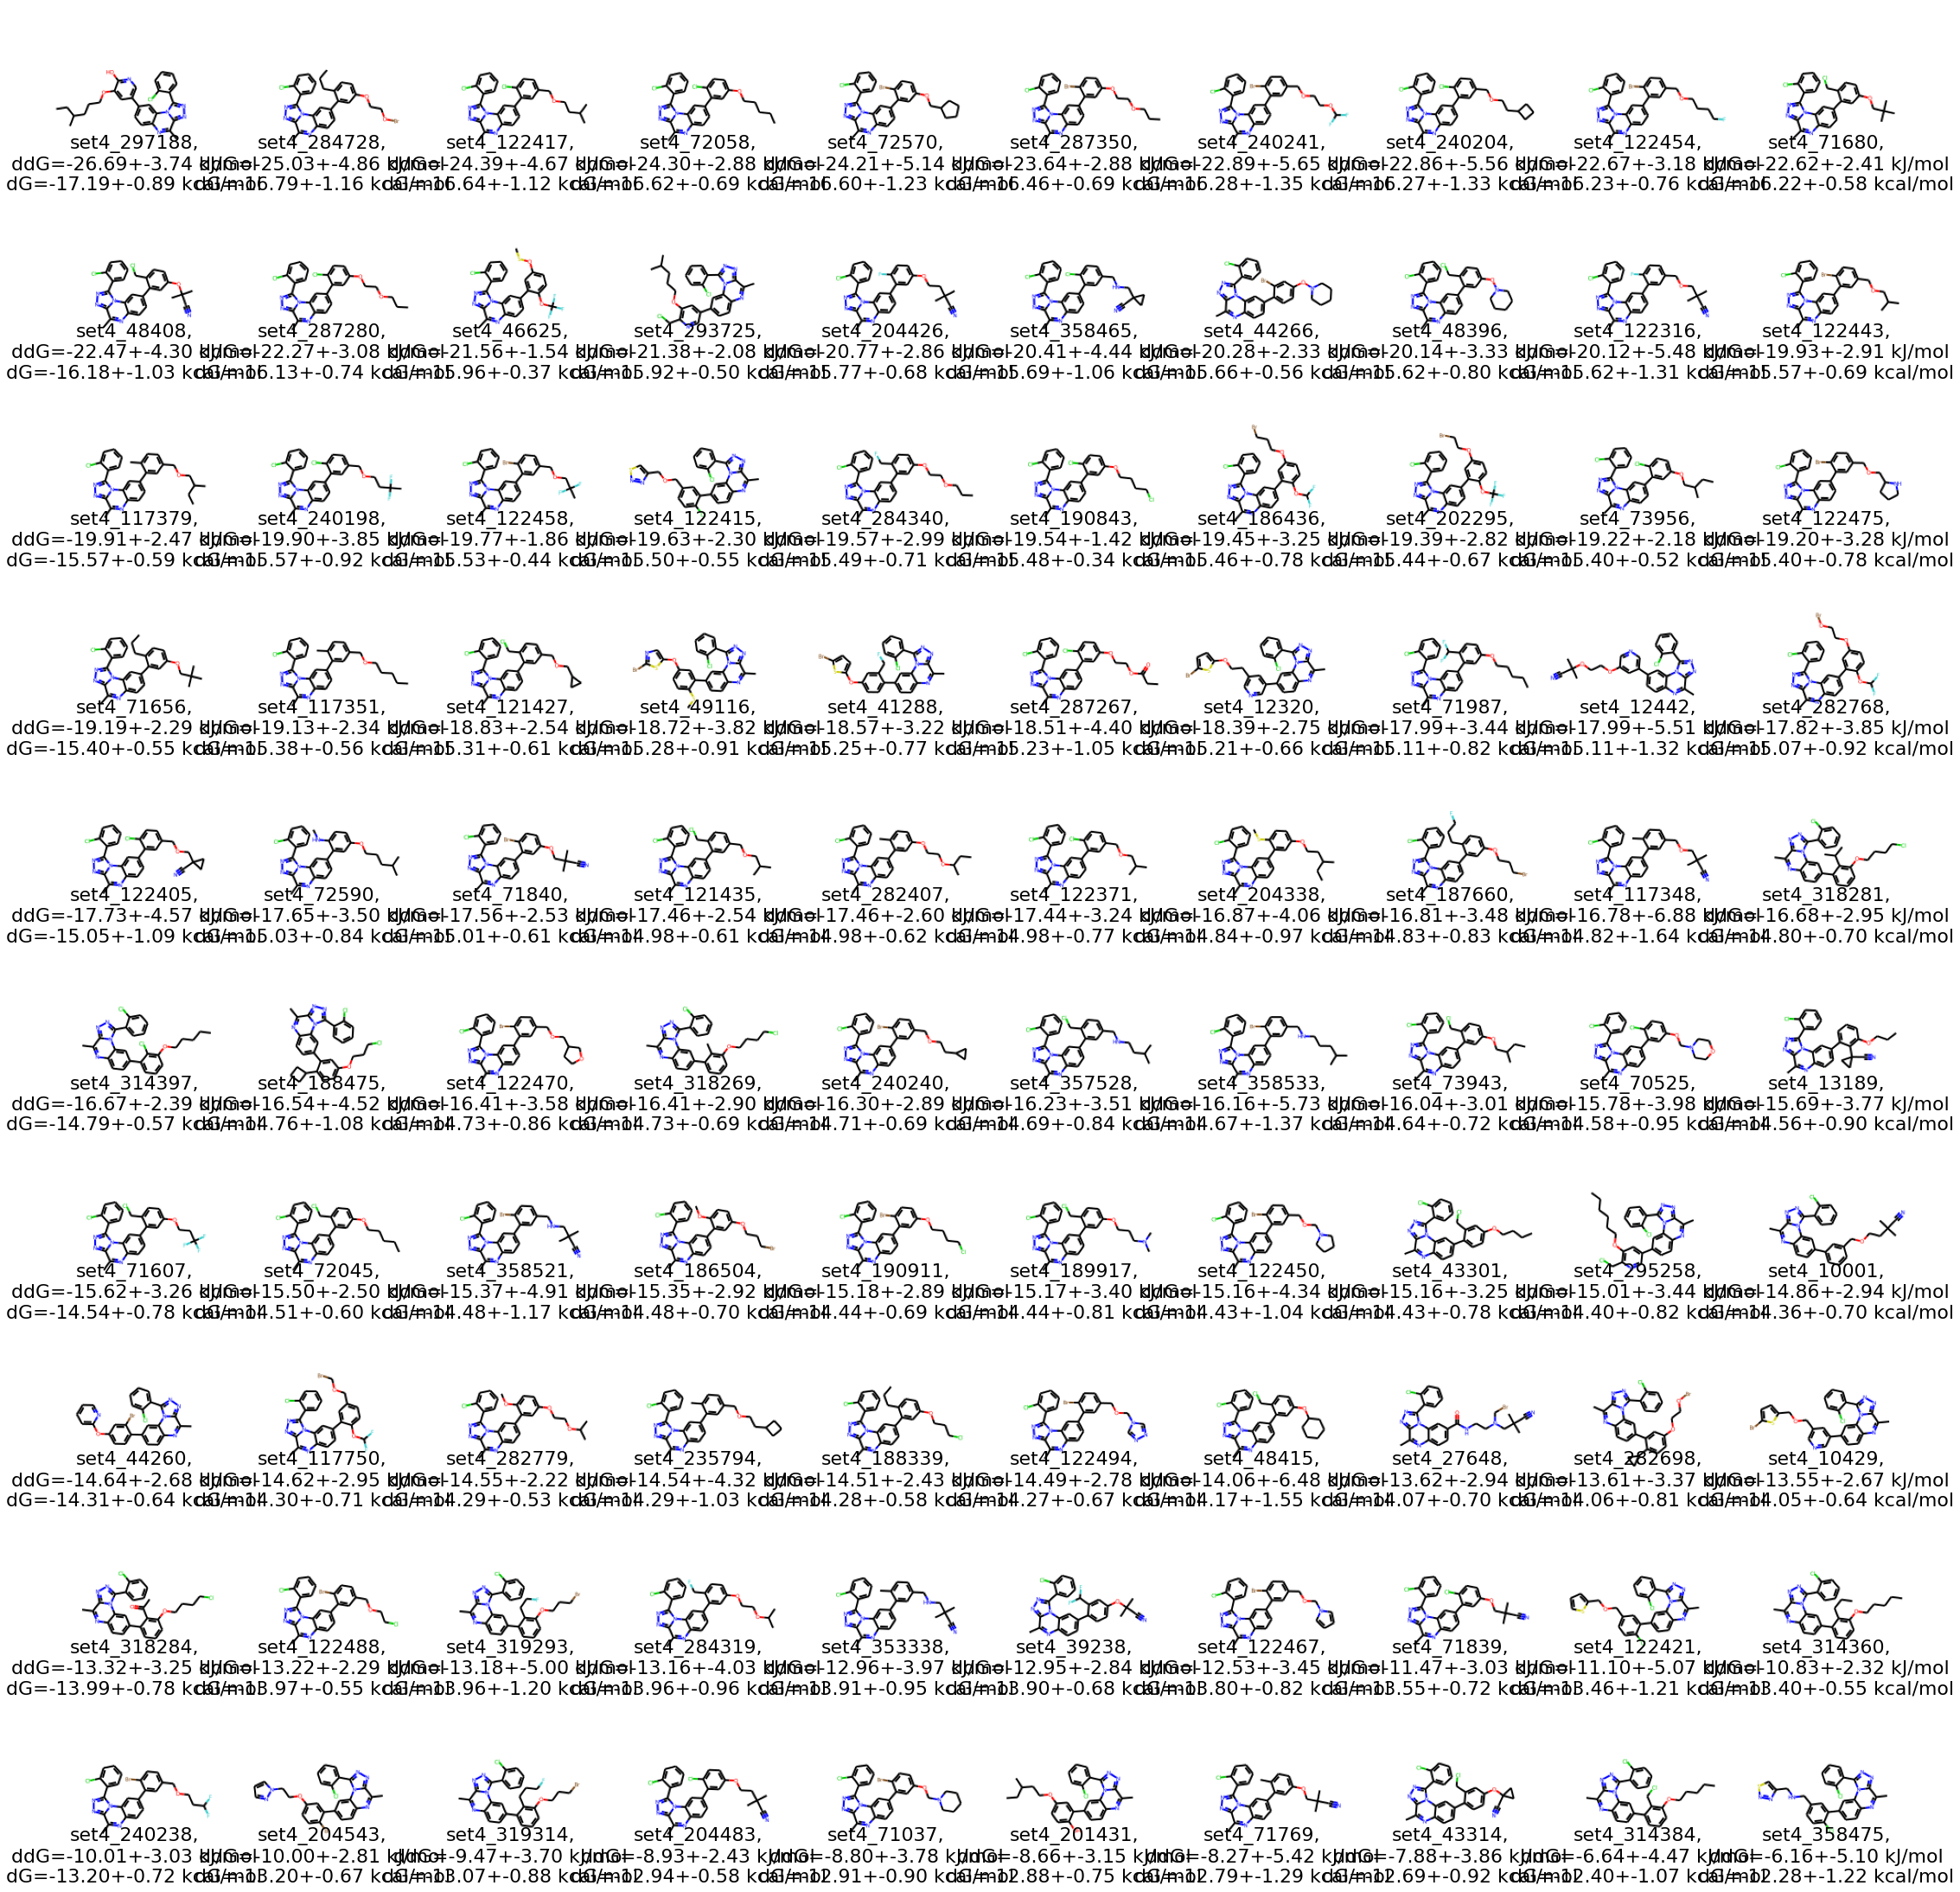

In [28]:
cutoff_ddg=-16

cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

tight_binders=[]
legends=[]
tight_dGs=[]
for i,l in enumerate(test_ligs):
    edge=f"edge_JAN_PDE2_1345_{l.GetProp('ID')}"
    if(edge in finished_edges):
        val=fe.resultsSummary.at[edge,'val']
        uncert=fe.resultsSummary.at[edge,'err_boot']
#         if(val<cutoff_ddg):
        tight_binders.append(Chem.MolFromSmiles(Chem.MolToSmiles(l)))
        legends.append(f"{l.GetProp('ID')},\nddG={val:.2f}+-{uncert:.2f} kJ/mol\ndG={fe.resultsSummary.loc[edge,'val']/cal2J + red_dG: .2f}+-{uncert/cal2J:.2f} kcal/mol")
        tight_dGs.append(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG)
order=np.argsort(tight_dGs)
            
# Draw.MolsToGridImage([tight_binders[i] for i in order],
#                      legends=[legends[i] for i in order],
#                      subImgSize = (200,200), molsPerRow=5, maxMols=101)

   
grid_mols_with_annotation([tight_binders[i] for i in order], [legends[i] for i in order],
                     sub_img_size =(200,200), mols_per_row=10, y_offset=-5)

In [29]:
print(len(tight_binders))

100


In [30]:
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

ordered_ligs_Rgroup_only=[]

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], [tight_binders[i] for i in order], asSmiles=True)# print(unmatched)
if(len(unmatched)>0):
    raise()

for i,l in enumerate(res):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        Rgroup_smi=new_l['R1']
        smi_params=Chem.rdmolfiles.SmilesParserParams()
        smi_params.removeHs=True
        Rgroup=Chem.AddHs(Chem.MolFromSmiles(Rgroup_smi))
        Rgroup_smi=Chem.MolToSmiles(Rgroup)
#         Rgroup_smi=Rgroup_smi.replace("[*:1]", "[*:R_2]")
#         Rgroup_smi=Rgroup_smi.replace("()", "")
        Rgroup=Chem.MolFromSmiles(Rgroup_smi, smi_params)

        for i in range(Rgroup.GetNumAtoms()):
            symb=Rgroup.GetAtomWithIdx(i).GetSymbol()
            if(symb=="*"):
                Rgroup.GetAtomWithIdx(i).SetProp("_displayLabel","R<sub>core</sub>")

        ordered_ligs_Rgroup_only.append(Chem.PropertyMol.PropertyMol(Rgroup))

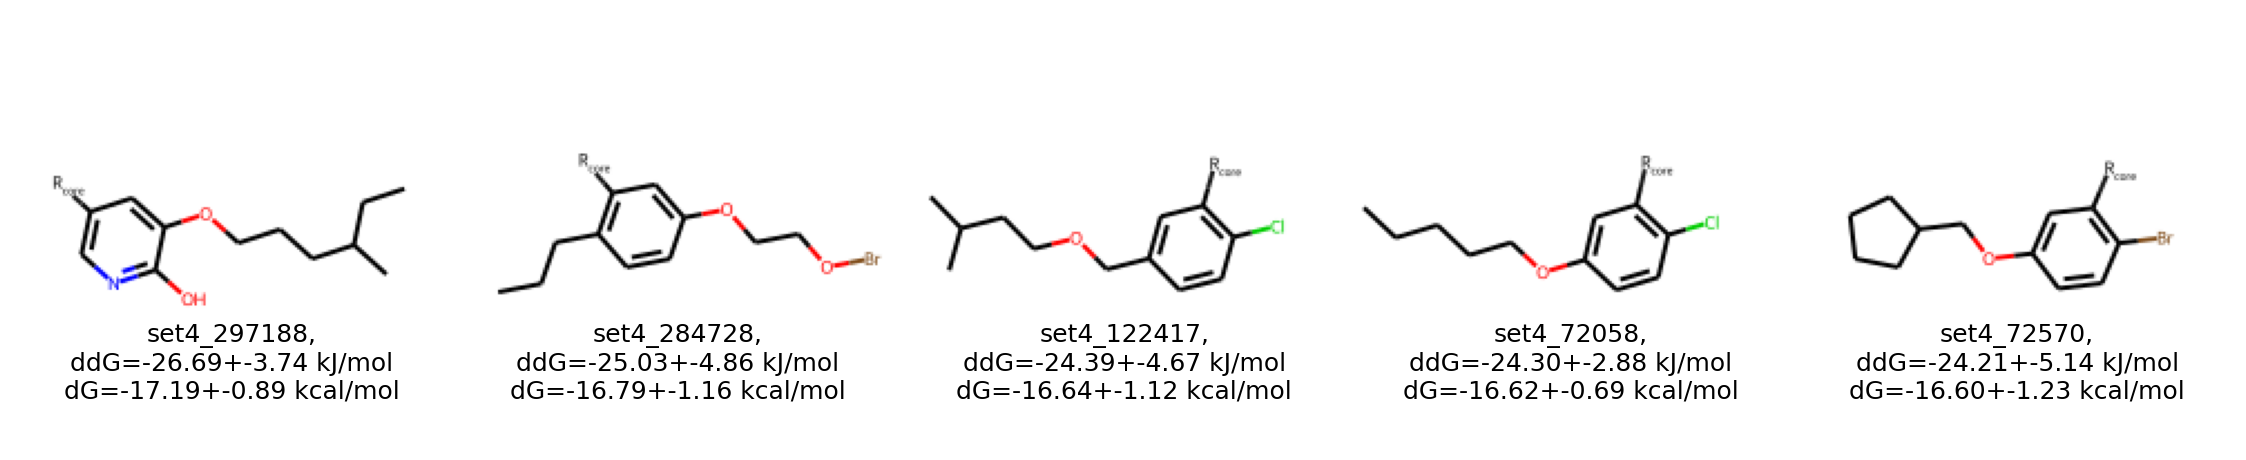

In [31]:
grid_mols_with_annotation(ordered_ligs_Rgroup_only[:5],
                 labels=[legends[i] for i in order[:5]],
                 sub_img_size = (200,200), mols_per_row=5, annotation_size=25, y_offset=-25)

### save preliminary results for finished ligands

In [86]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
# red_dG=lig_to_dG(reference_lig)

# save_ligs=[]
# for edge in fe.resultsSummary.index:
#     ligname=edge[19:]
#     for lig in test_ligs:
#         if lig.GetProp('ID')==ligname:
#             lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
#             lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
#             lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
#             save_ligs.append(PropertyMol.PropertyMol(lig))
            
# print(len(save_ligs))

# fname="finished_ligs_prelim.pickle"

# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

# save the stable ligs as a pickle for training

In [55]:
cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

save_ligs=[]
for edge in fe.resultsSummary.index:
    ligname=edge[19:]
    for lig in test_ligs:
        if lig.GetProp('ID')==ligname:
            lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
            lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
            lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
            save_ligs.append(PropertyMol.PropertyMol(lig))
            
print(len(save_ligs))

fname="stable_ligs.pickle"

with  open( fname, "wb" ) as f:
    pickle.dump(save_ligs, f)

100


In [84]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))

# print(f"ref lig dG: {lig_to_dG(reference_lig)} kcal/mol")

In [85]:
# # fix the saved ligands' dG values
# fname="stable_ligs.pickle"
# with open(fname, 'rb') as f:
#     save_ligs = pickle.load(f)
    
# red_dG=lig_to_dG(reference_lig)
    
# for i,lig in enumerate(save_ligs):
#     ddG=float(lig.GetProp("ddG"))
#     lig.SetProp("dG", str(ddG + red_dG) ) # kcal/mol
#     save_ligs[i]=PropertyMol.PropertyMol(lig)
    
# fname="stable_ligs_fixed_dG.pickle"
# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

# Also write dG value into the big 34K lig DB pickle file

In [32]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step5_dG.pickle"
with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open("stable_ligs.pickle", 'rb') as f:
# with open("finished_ligs_prelim.pickle", 'rb') as f:
    step_known_ligs = pickle.load(f)

known_lig_idxs_in_set4f=[]
known_lig_idxs_in_step=[]
known_lig_idxs=[l.GetProp('ID') for l in step_known_ligs]
for i,lig in enumerate(ligs_set4f):
    if(lig.GetProp('ID') in known_lig_idxs):
        known_lig_idxs_in_set4f.append(i)
        known_lig_idxs_in_step.append(known_lig_idxs.index(lig.GetProp('ID')))

In [33]:
print(known_lig_idxs_in_step)
print(known_lig_idxs_in_set4f)

[5, 36, 26, 82, 91, 93, 41, 74, 57, 46, 75, 99, 66, 63, 88, 27, 87, 53, 6, 85, 92, 8, 34, 69, 4, 58, 60, 10, 52, 24, 13, 19, 79, 54, 77, 29, 68, 84, 48, 20, 0, 31, 37, 32, 47, 23, 2, 51, 42, 7, 97, 62, 98, 1, 67, 33, 49, 45, 55, 35, 43, 94, 12, 95, 18, 72, 65, 9, 14, 40, 71, 3, 44, 11, 76, 59, 22, 39, 64, 50, 17, 30, 15, 90, 89, 38, 83, 28, 56, 86, 16, 96, 80, 61, 81, 78, 21, 25, 70, 73]
[4152, 4349, 4962, 5002, 5162, 9483, 9675, 10650, 11070, 11083, 11453, 11458, 12558, 12911, 12923, 12929, 13126, 13581, 13760, 13900, 13918, 13919, 13943, 13953, 13954, 13973, 13987, 13990, 14070, 14076, 14279, 14282, 14630, 14632, 14648, 14783, 15179, 15183, 15300, 15336, 15362, 15365, 15367, 15370, 15386, 15392, 15394, 15398, 15406, 15407, 15411, 15416, 15421, 20883, 20897, 20977, 21014, 21018, 21025, 21102, 21128, 21337, 21410, 21501, 21519, 21554, 21591, 22316, 22542, 22544, 22549, 22551, 22552, 26918, 26980, 26984, 26989, 27099, 27104, 27122, 27199, 27206, 27231, 27395, 27542, 27580, 27795, 27796,

In [34]:
for i in range(len(known_lig_idxs_in_step)):
    idx_step=known_lig_idxs_in_step[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step_known_ligs[idx_step]
    new_lig=ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)

fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step6_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(ligs_set4f, f)
    
del ligs_set4f

In [35]:
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step5_dG.pickle"

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)
    
    
for i in range(len(known_lig_idxs_in_step)):
    idx_step=known_lig_idxs_in_step[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step, idx_set4f)
    
    old_lig=step_known_ligs[idx_step]
    new_lig=no_core_ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    no_core_ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step6_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(no_core_ligs_set4f, f)
    
del no_core_ligs_set4f